В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.
 

**Задание 1**

Retention – один из самых важных показателей в компании. 

Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Импортируем библиотеки

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import pingouin as pg
import scipy


In [58]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-artem-kuznetsov/shared/problem1-reg_data.csv',sep = ';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-artem-kuznetsov/shared/problem1-auth_data.csv',sep = ';')


Смотрим датасет reg_data с данными о времени регистрации

In [59]:
 reg_data.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


Доавляем колонку date  в формате datetime

In [60]:
reg_data['reg_date'] = pd.to_datetime(reg_data.reg_ts, unit='s')
reg_data.head(5)  

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,947802447,3,2000-01-13 22:27:27
3,959523541,4,2000-05-28 14:19:01
4,969103313,5,2000-09-16 11:21:53


Проверяем датасет на NaN значения

In [61]:
 reg_data.isna().sum()

reg_ts      0
uid         0
reg_date    0
dtype: int64

Проверяем колонку с id на уникальность значений

In [62]:
reg_data.shape[0] == reg_data.uid.nunique()

True

Смотрим датасет auth_data с данными о времени авторизации

In [63]:
 auth_data.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Проверяем датасет на NaN значения

In [64]:
 auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Доавляем колонку auth_date в формате datetime

In [65]:
auth_data['auth_date'] = pd.to_datetime(auth_data.auth_ts, unit='s')
auth_data.head(5)

,auth_ts,uid,auth_date
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46
3,933393015,2,1999-07-31 03:50:15
4,933875379,2,1999-08-05 17:49:39


In [66]:
def raschet_retention(reg_data, auth_data):
    
    #Объединяем два датасета по uid
    auth_reg = auth_data.merge(reg_data, on='uid')
    
    #Переводим колонки auth_ts и reg_ts из формата timestamp в формат datetime
    auth_reg['reg_ts'] = pd.to_datetime(auth_reg['reg_ts'],unit='s').dt.normalize()
    auth_reg['auth_ts'] = pd.to_datetime(auth_reg['auth_ts'],unit='s').dt.normalize()
    
    #Добавляем колонку day_distance в которой посчитаем сколько дней прошло от момента регистрации до авторизации
    auth_reg['day_distance'] = auth_reg.auth_ts - auth_reg.reg_ts
    
    #Группируем пользователей по дням
    users_day = auth_reg.groupby('day_distance', as_index=False)\
                    .agg({'uid':'count'})\
                    .rename(columns={'uid': 'users'})
    
    #Рассчитываем retention
    users_day['retention'] = users_day.users / users_day.users.loc[0] * 100
    users_day['retention'] = round(users_day['retention'], 2)
    
     
    
    
    
    return users_day
   

Проверяем работу функции 

In [67]:
 raschet_retention(reg_data,auth_data)

,day_distance,users,retention
0,0 days,1000000,100.00
1,1 days,20071,2.01
2,2 days,40997,4.10
3,3 days,46338,4.63
4,4 days,52258,5.23
...,...,...,...
5911,7716 days,1,0.00
5912,7720 days,1,0.00
5913,7721 days,1,0.00
5914,7727 days,1,0.00


**Задание 2**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [68]:
ab_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-artem-kuznetsov/final_project/Проект_1_Задание_2.csv',sep = ';')
ab_test.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Узнаем количество значений в датасете

In [69]:
ab_test.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

Видим, что датасет содержит две тестовых группы. Посчитаем количество пользователей в группах

In [70]:
test_a = ab_test.query("testgroup == 'a'").user_id.count()
test_b = ab_test.query("testgroup == 'b'").user_id.count()


In [71]:
test_a

202103

In [72]:
test_b

202667

Видим, что группы поделены практически поровну

Посчитаем сумму выручки в группах

In [73]:
revenue_a = ab_test.query("testgroup == 'a'").revenue.sum()
revenue_b = ab_test.query("testgroup == 'b'").revenue.sum()

In [74]:
revenue_a 

5136189

In [75]:
revenue_b

5421603

In [76]:
revenue_a - revenue_b

-285414

Сумма выручки в группе 'b' больше на 285414

Посчитаем средний чек по группам 

In [77]:
avg_check_a = round(ab_test.query("testgroup == 'a' and revenue > 0").revenue.mean())
avg_check_b = round(ab_test.query("testgroup == 'b' and revenue > 0").revenue.mean())

In [78]:
avg_check_a

2664

In [79]:
avg_check_b

3004

In [80]:
avg_check_a - avg_check_b

-340

Средний чек в группе 'b' больше на 340

Посчитаем максимальный чек по группам

In [81]:
max_check_a = round(ab_test.query("testgroup == 'a' and revenue > 0").revenue.max())
max_check_b = round(ab_test.query("testgroup == 'b' and revenue > 0").revenue.max())

In [82]:
max_check_a

37433

In [83]:
max_check_b

4000

In [84]:
max_check_a - max_check_b

33433

Максимальный чек в группе 'a' выше на 33433, что выглядит довольно странно.

Посчитаем минимальный чек


In [85]:
min_check_a = round(ab_test.query("testgroup == 'a' and revenue > 0").revenue.min())
min_check_b = round(ab_test.query("testgroup == 'b' and revenue > 0").revenue.min())

In [86]:
min_check_a

200

In [87]:
min_check_b

2000

In [88]:
min_check_a - min_check_b

-1800

Минимальный чек выше в группе 'b' на 1800

Посчитаем медианный средний чек

In [89]:
median_rev_a = ab_test.query("testgroup == 'a'").revenue.median()
median_rev_b = ab_test.query("testgroup == 'b'").revenue.median()

In [90]:
median_rev_a

0.0

In [91]:
median_rev_b

0.0

Медианный средний чек равен 0. Т.к большинство польователей не совершили покупку

Посчитаем количество платящих пользователей в группах

In [92]:
pay_user_a = ab_test.query("testgroup == 'a' and revenue > 0").revenue.count()
pay_user_b = ab_test.query("testgroup == 'b' and revenue > 0").revenue.count()

In [93]:
pay_user_a

1928

In [94]:
pay_user_b

1805

Количество платящих пользователей в группе 'a' больше

Считаем 

ARPU - средняя выручка на одного пользователя

ARPPU - средняя выручка на одного платящего пользователяCR - конверсию в покупку

In [95]:
arpu_a = revenue_a / test_a
arpu_b = revenue_b / test_b

arppu_a = revenue_a / pay_user_a
arppu_b = revenue_b / pay_user_b

In [96]:
arpu_a

25.413719736965806

In [97]:
arpu_b

26.75128659327863

In [98]:
arppu_a

2663.9984439834025

In [99]:
arppu_b

3003.6581717451522

In [100]:
# конверсия
cr_a = (pay_user_a / test_a)*100
cr_b = (pay_user_b / test_b)*100

In [101]:
cr_a

0.9539690157988748

In [102]:
cr_b

0.8906235351586593

Для наглядности объеденим полученные значения в датафрейм

In [103]:
metrics = pd.DataFrame({'users_sum': [test_a, test_b],
              'pay_users': [pay_user_a, pay_user_b],
              'avg_check':[avg_check_a, avg_check_b],
              'median_rev':[median_rev_a, median_rev_b],
              'max_check':[max_check_a, max_check_b],
              'min_check':[min_check_a, min_check_b],
              'ARPPU':[arppu_a, arppu_b],
              'CR':[cr_a,cr_b],
              'ARPU':[arpu_a, arpu_b],
              'revenue_sum':[revenue_a, revenue_b]},
index=['a', 'b'])

metrics

,users_sum,pay_users,avg_check,median_rev,max_check,min_check,ARPPU,CR,ARPU,revenue_sum
a,202103,1928,2664,0.0,37433,200,2663.998444,0.953969,25.413720,5136189
b,202667,1805,3004,0.0,4000,2000,3003.658172,0.890624,26.751287,5421603


_______________________________________

Посмотрим распределение выручки в группах на графике

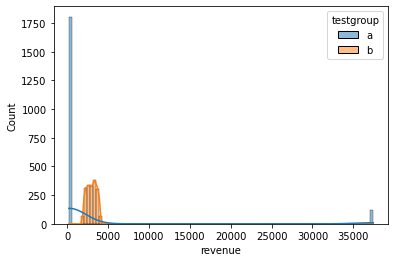

In [104]:
visual_rev = sns.histplot(data=ab_test.query('revenue > 0'), 
                  x='revenue', 
                  hue='testgroup', 
                  kde=True, 
                  bins=100) 

По графику видим что распредение не является нормальным.

_____________________________________________________

Посмотрим количество пользователей с чеком больше 30000 

In [105]:
ab_test[ab_test.revenue > 30000].shape[0]

123

___________________________________________________

**T-test**

Проверим есть ли различие по revenue у двух групп с помощью t-теста. t-тест в данном случае, несмотря на выбросы, можно использовать, т.к. выборка очень большая

H0 - различий по revenue у групп нет

H1 - группы различаются по revenue

In [106]:
pg.ttest(x=ab_test[ab_test.testgroup == 'a'].revenue,
         y=ab_test[ab_test.testgroup == 'b'].revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


P-value 0.53, поэтому принимаем нулевую гипотезу. Различий по revenue в группах нет.

_______________________________________________________

**Хи-квадрат**

Также попробуем проверить статзначимость различий CR в двух группах. Будем использовать критерий Хи-квадрат

H0 – различий между тестовой и контрольной группами нет

H1 – различия между контрольной и тестовой группами есть

In [107]:
ab_test['pay'] = ab_test['revenue'] > 0
pd.crosstab(ab_test['testgroup'], ab_test['pay'])

pay,False,True
testgroup,,
a,200175,1928
b,200862,1805


In [108]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(ab_test['testgroup'], ab_test['pay']))
p

0.03647561892312613

P-value 0.03 поэтому отклоняем нулевую гипотезу



_________________________________________________

**Вывод:**

*Судя по проведенным рассчетам и тестам, сложно однозначно ответить какой набор предложений лучше. В тестовой группе ниже конверсия в покупку, однако выше выручка. Доход на одного пользователя практически одинаковый. Количество пользователей с чеком выше 30000 составляетя 123 человека, предположим, что это все-таки не выброс. Но это сильно влияет на средний чек. Можно сделать вывод, набор преложений для группы 'a', большо подошел для состоятельных пользователей, забыв при этом про средний сегмент*

**Я бы оставил набор предложений для группы 'b'**, т.к при меньшем количетсве пользователей, меньшей конверсии в покупку, в итоге средний чек оказался даже выше, чем группе 'a' c максимальным чеком > 30к. Так же в группе 'b' выше ARPU и ARPPU.






_________________________________________

**Задание 3**

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 

**С помощью каких метрик можно оценить результаты последнего прошедшего события?**

1. Количество участников, прошедших уровни
2. Время, затраченное на прохождение уровня
3. Количество уровней, пройденных участниками
4. Количество монет или бонусов, заработанных различными участниками
5. Скорость прохождения уровней для каждого участника
6. Среднее время, затраченное на прохождение уровней
7. Процент участников, прошедших все уровни
8. Количество пользователей пришедших в игру во время события.

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 

**Изменится ли набор метрик оценки результата? Если да, то как?**

Да, набор метрик оценки результата изменится. 



1. Количество пройденных уровней
2. Количество легких уровней( после которых реже всего происходит откат)
3. Количество сложных уровней после которых чаще всего происходит откат назад
2. Среднее количество попыток на один уровень(сложный)
3. Среднее время, затраченное на прохождение одного уровня(сложный)
4. Доля успешных попыток выполнения уровня(сложный)
5. Количество пользователей не вернувшихся в игру после отката назад
6. Среднее время прохождения игры с учетом возвратов
7. Число возвратов на предидущие уровни



_____________________

__________________________________________